In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
# Load raw train and test CSV files from the dataset folder
DATA_DIR = "dataset"

train_path = os.path.join(DATA_DIR, "train.csv")
test_path = os.path.join(DATA_DIR, "test.csv")

train_df_raw = pd.read_csv(train_path)
test_df_raw = pd.read_csv(test_path)

print("Raw train shape:", train_df_raw.shape)
print("Raw test shape :", test_df_raw.shape)

train_df_raw.head()


Raw train shape: (59598, 24)
Raw test shape : (14900, 24)


,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed


In [3]:
train_df = train_df_raw.copy()
test_df = test_df_raw.copy()

ID_COL = "Employee ID"
TARGET_COL = "Attrition"


In [4]:
# Check and handle duplicate rows and duplicate Employee IDs within each dataset
# 1) Full row duplicates in train and test
train_full_dups = train_df.duplicated().sum()
test_full_dups = test_df.duplicated().sum()

print(f"Full row duplicates in train: {train_full_dups}")
print(f"Full row duplicates in test : {test_full_dups}")

if train_full_dups > 0:
    train_df = train_df.drop_duplicates()
    print("Train shape after dropping full duplicates:", train_df.shape)

if test_full_dups > 0:
    test_df = test_df.drop_duplicates()
    print("Test shape after dropping full duplicates :", test_df.shape)

# 2) Duplicate Employee IDs within each dataset
train_id_dups = train_df[ID_COL].duplicated().sum()
test_id_dups = test_df[ID_COL].duplicated().sum()

print(f"\nDuplicate {ID_COL} in train: {train_id_dups}")
print(f"Duplicate {ID_COL} in test : {test_id_dups}")

if train_id_dups > 0:
    train_df = train_df.drop_duplicates(subset=[ID_COL], keep="first")
    print("Dropped duplicate IDs in train. New shape:", train_df.shape)

if test_id_dups > 0:
    test_df = test_df.drop_duplicates(subset=[ID_COL], keep="first")
    print("Dropped duplicate IDs in test. New shape:", test_df.shape)


Full row duplicates in train: 0
Full row duplicates in test : 0

Duplicate Employee ID in train: 0
Duplicate Employee ID in test : 0


In [5]:
# Check missing values (count and percentage) in train and test
def missing_summary(df, name):
    print(f"=== Missing values in {name} ===")
    mis_count = df.isna().sum()
    mis_pct = (mis_count / len(df)) * 100
    summary = pd.DataFrame({
        "missing_count": mis_count,
        "missing_pct": mis_pct
    })
    print(summary.sort_values("missing_pct", ascending=False))

missing_summary(train_df, "train")
print()
missing_summary(test_df, "test")


=== Missing values in train ===
                          missing_count  missing_pct
Employee ID                           0          0.0
Age                                   0          0.0
Gender                                0          0.0
Years at Company                      0          0.0
Job Role                              0          0.0
Monthly Income                        0          0.0
Work-Life Balance                     0          0.0
Job Satisfaction                      0          0.0
Performance Rating                    0          0.0
Number of Promotions                  0          0.0
Overtime                              0          0.0
Distance from Home                    0          0.0
Education Level                       0          0.0
Marital Status                        0          0.0
Number of Dependents                  0          0.0
Job Level                             0          0.0
Company Size                          0          0.0
Company Tenure

In [6]:
# Detect constant (zero-variance) features using only train, and drop them from both train and test
def find_constant_features(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
    nunique = df.nunique()
    const_feats = [col for col, n in nunique.items() if (n == 1 and col not in exclude_cols)]
    return const_feats

exclude_from_constant = [ID_COL, TARGET_COL]

constant_features_train = find_constant_features(train_df, exclude_cols=exclude_from_constant)
print("Constant features in train:", constant_features_train)

if constant_features_train:
    print("\nDropping constant features from train and test:", constant_features_train)
    train_df.drop(columns=constant_features_train, inplace=True)
    test_df.drop(columns=constant_features_train, inplace=True)
else:
    print("\nNo constant features found in train.")


Constant features in train: []

No constant features found in train.


In [7]:
# Identify numeric and categorical feature columns (excluding ID and target)
feature_cols = [c for c in train_df.columns if c not in [ID_COL, TARGET_COL]]

numeric_features = train_df[feature_cols].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = train_df[feature_cols].select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns :", numeric_features)
print("\nCategorical cols:", categorical_features)


Numeric columns : ['Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents', 'Company Tenure']

Categorical cols: ['Gender', 'Job Role', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Overtime', 'Education Level', 'Marital Status', 'Job Level', 'Company Size', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition']


In [8]:
# Checking for Outliers based on IQR method on the train set
def compute_iqr_bounds(df, numeric_columns):
    bounds = {}
    summary_rows = []
    for col in numeric_columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        bounds[col] = {"q1": q1, "q3": q3, "iqr": iqr, "lower": lower, "upper": upper}

        summary_rows.append({
            "feature": col,
            "n_outliers_train": outliers
        })
    summary_df = pd.DataFrame(summary_rows).set_index("feature")
    return bounds, summary_df

iqr_bounds, outlier_summary = compute_iqr_bounds(train_df, numeric_features)

outlier_summary


,n_outliers_train
feature,
Age,0
Years at Company,273
Monthly Income,50
Number of Promotions,0
Distance from Home,0
Number of Dependents,0
Company Tenure,0


In [9]:
# Apply outlier capping (winsorization) to both train and test using train-derived bounds
def cap_outliers(df, numeric_columns, bounds_dict):
    df = df.copy()
    for col in numeric_columns:
        lower = bounds_dict[col]["lower"]
        upper = bounds_dict[col]["upper"]
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df

train_df_capped = cap_outliers(train_df, numeric_features, iqr_bounds)
test_df_capped = cap_outliers(test_df, numeric_features, iqr_bounds)


In [10]:
# Cell 13: Encoding the target Attrition
target_mapping = {"Stayed": 0, "Left": 1}


In [11]:
# Save Employee IDs separately and drop them from the feature dataframes
train_ids = train_df_capped[ID_COL].copy()
test_ids = test_df_capped[ID_COL].copy()

train_df_capped = train_df_capped.drop(columns=[ID_COL])
test_df_capped = test_df_capped.drop(columns=[ID_COL])


In [12]:
# Re-identify numeric and categorical features after cleaning (excluding Attrition target)
feature_cols_clean = [c for c in train_df_capped.columns if c != TARGET_COL]

numeric_features = train_df_capped[feature_cols_clean].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = train_df_capped[feature_cols_clean].select_dtypes(include=["object"]).columns.tolist()

print("Numeric features   :", numeric_features)
print("Categorical features:", categorical_features)


Numeric features   : ['Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents', 'Company Tenure']
Categorical features: ['Gender', 'Job Role', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Overtime', 'Education Level', 'Marital Status', 'Job Level', 'Company Size', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition']


In [13]:
# Split categorical features into ordinal and nominal with defined logical orders

ordinal_categorical_features = [
    "Work-Life Balance",
    "Job Satisfaction",
    "Performance Rating",
    "Education Level",
    "Job Level",
    "Company Size",          
    "Company Reputation",
    "Employee Recognition",
]

ordinal_categories = [
    ["Poor", "Fair", "Good", "Excellent"],                         # Work-Life Balance
    ["Low", "Medium", "High", "Very High"],                        # Job Satisfaction
    ["Low", "Below Average", "Average", "High"],                   # Performance Rating
    ["High School", "Associate Degree", "Bachelor’s Degree",
     "Master’s Degree", "PhD"],                                    # Education Level
    ["Entry", "Mid", "Senior"],                                    # Job Level
    ["Small", "Medium", "Large"],                                  # Company Size
    ["Poor", "Fair", "Good", "Excellent"],                         # Company Reputation
    ["Low", "Medium", "High", "Very High"],                        # Employee Recognition
]

nominal_categorical_features = [c for c in categorical_features if c not in ordinal_categorical_features]

print("Ordinal categorical features:", ordinal_categorical_features)
print("Nominal categorical features:", nominal_categorical_features)


Ordinal categorical features: ['Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Education Level', 'Job Level', 'Company Size', 'Company Reputation', 'Employee Recognition']
Nominal categorical features: ['Gender', 'Job Role', 'Overtime', 'Marital Status', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities']


In [14]:
# Prepare X (features) and y (encoded target) for preprocessing and later modeling
X_train_full = train_df_capped[feature_cols_clean].copy()
y_train_full = train_df_capped[TARGET_COL].map(target_mapping).copy()

X_test_full = test_df_capped[feature_cols_clean].copy()
y_test_full = test_df_capped[TARGET_COL].map(target_mapping).copy()

print("X_train_full shape:", X_train_full.shape)
print("y_train_full shape:", y_train_full.shape)
print("X_test_full shape :", X_test_full.shape)
print("y_test_full shape :", y_test_full.shape)
print("\nEncoded target values in train:")
print(y_train_full.value_counts())
print("\nEncoded target values in test:")
print(y_test_full.value_counts())


X_train_full shape: (59598, 22)
y_train_full shape: (59598,)
X_test_full shape : (14900, 22)
y_test_full shape : (14900,)

Encoded target values in train:
Attrition
0    31260
1    28338
Name: count, dtype: int64

Encoded target values in test:
Attrition
0    7868
1    7032
Name: count, dtype: int64


In [15]:
# Define preprocessing pipelines for numeric, ordinal, and nominal features
# Numeric transformer: impute missing values with median, then standardize
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Ordinal transformer: impute with most frequent, then apply ordinal encoding with specified category order
ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=ordinal_categories))
])

# Nominal transformer: impute with most frequent, then one-hot encode with unknowns ignored
nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer to apply the appropriate transformations to each group of features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ord", ordinal_transformer, ordinal_categorical_features),
        ("nom", nominal_transformer, nominal_categorical_features),
    ]
)


In [16]:
# Fit the preprocessor on train features only and transform both train and test for sanity check
preprocessor.fit(X_train_full)

X_train_processed = preprocessor.transform(X_train_full)
X_test_processed = preprocessor.transform(X_test_full)

print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape :", X_test_processed.shape)


X_train_processed shape: (59598, 33)
X_test_processed shape : (14900, 33)


In [17]:
# Cell 21: Inspect processed feature names for later model interpretation and analysis
processed_feature_names = preprocessor.get_feature_names_out()
print("Number of processed features:", len(processed_feature_names))
processed_feature_names[:50]  # show first 50 as a sample


Number of processed features: 33


array(['num__Age', 'num__Years at Company', 'num__Monthly Income',
       'num__Number of Promotions', 'num__Distance from Home',
       'num__Number of Dependents', 'num__Company Tenure',
       'ord__Work-Life Balance', 'ord__Job Satisfaction',
       'ord__Performance Rating', 'ord__Education Level',
       'ord__Job Level', 'ord__Company Size', 'ord__Company Reputation',
       'ord__Employee Recognition', 'nom__Gender_Female',
       'nom__Gender_Male', 'nom__Job Role_Education',
       'nom__Job Role_Finance', 'nom__Job Role_Healthcare',
       'nom__Job Role_Media', 'nom__Job Role_Technology',
       'nom__Overtime_No', 'nom__Overtime_Yes',
       'nom__Marital Status_Divorced', 'nom__Marital Status_Married',
       'nom__Marital Status_Single', 'nom__Remote Work_No',
       'nom__Remote Work_Yes', 'nom__Leadership Opportunities_No',
       'nom__Leadership Opportunities_Yes',
       'nom__Innovation Opportunities_No',
       'nom__Innovation Opportunities_Yes'], dtype=object)

# Feature Engineering

In [ ]:
# Inspect cleaned dataframes and recompute base numeric/categorical feature lists

print("train_df_capped shape:", train_df_capped.shape)
print("test_df_capped shape :", test_df_capped.shape)
print("Columns:", train_df_capped.columns.tolist())

base_feature_cols = [c for c in train_df_capped.columns if c != TARGET_COL]

base_numeric_features = train_df_capped[base_feature_cols].select_dtypes(include=["int64", "float64"]).columns.tolist()
base_categorical_features = train_df_capped[base_feature_cols].select_dtypes(include=["object"]).columns.tolist()

print("Base numeric features   :", base_numeric_features)
print("Base categorical features:", base_categorical_features)


train_df_capped shape: (59598, 23)
test_df_capped shape : (14900, 23)
Columns: ['Age', 'Gender', 'Years at Company', 'Job Role', 'Monthly Income', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Number of Promotions', 'Overtime', 'Distance from Home', 'Education Level', 'Marital Status', 'Number of Dependents', 'Job Level', 'Company Size', 'Company Tenure', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition', 'Attrition']
Base numeric features   : ['Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents', 'Company Tenure']
Base categorical features: ['Gender', 'Job Role', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Overtime', 'Education Level', 'Marital Status', 'Job Level', 'Company Size', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition']


In [19]:
# Create copies for feature engineering so original capped dataframes remain untouched
train_fe = train_df_capped.copy()
test_fe = test_df_capped.copy()

print("Feature-engineering train shape:", train_fe.shape)
print("Feature-engineering test shape :", test_fe.shape)


Feature-engineering train shape: (59598, 23)
Feature-engineering test shape : (14900, 23)


In [20]:
# Compute train-only bins/thresholds for age, tenure, income, and distance
# AgeGroup: 4 bins using quartiles (balanced groups)
age_min = train_fe["Age"].min()
age_max = train_fe["Age"].max()
age_q = train_fe["Age"].quantile([0.25, 0.5, 0.75]).values
age_bins = [age_min - 1, age_q[0], age_q[1], age_q[2], age_max + 1]
age_group_labels = ["Youngest", "Young", "Mid", "Senior"]

# TenureGroup (Years at Company): 4 bins using quartiles
tenure_min = train_fe["Years at Company"].min()
tenure_max = train_fe["Years at Company"].max()
tenure_q = train_fe["Years at Company"].quantile([0.25, 0.5, 0.75]).values
tenure_bins = [tenure_min - 1, tenure_q[0], tenure_q[1], tenure_q[2], tenure_max + 1]
tenure_group_labels = ["Very Short", "Short", "Medium", "Long"]

# IncomeBand: 4 bins using quartiles
income_min = train_fe["Monthly Income"].min()
income_max = train_fe["Monthly Income"].max()
income_q = train_fe["Monthly Income"].quantile([0.25, 0.5, 0.75]).values
income_bins = [income_min - 1, income_q[0], income_q[1], income_q[2], income_max + 1]
income_band_labels = ["Low", "Mid-Low", "Mid-High", "High"]

# DistanceBand: 3 bins using 33% and 66% quantiles; also long commute threshold at 75%
distance_min = train_fe["Distance from Home"].min()
distance_max = train_fe["Distance from Home"].max()
distance_q = train_fe["Distance from Home"].quantile([0.33, 0.66, 0.75]).values
distance_bins = [distance_min - 1, distance_q[0], distance_q[1], distance_max + 1]
distance_band_labels = ["Near", "Medium", "Far"]
long_commute_threshold = distance_q[2]  # 75th percentile

print("Age bins         :", age_bins, "labels:", age_group_labels)
print("Tenure bins      :", tenure_bins, "labels:", tenure_group_labels)
print("Income bins      :", income_bins, "labels:", income_band_labels)
print("Distance bins    :", distance_bins, "labels:", distance_band_labels)
print("Long commute thr :", long_commute_threshold)


Age bins         : [np.float64(17.0), np.float64(28.0), np.float64(39.0), np.float64(49.0), np.float64(60.0)] labels: ['Youngest', 'Young', 'Mid', 'Senior']
Tenure bins      : [np.float64(0.0), np.float64(7.0), np.float64(13.0), np.float64(23.0), np.float64(48.0)] labels: ['Very Short', 'Short', 'Medium', 'Long']
Income bins      : [np.float64(1315.0), np.float64(5658.0), np.float64(7354.0), np.float64(8880.0), np.float64(13714.0)] labels: ['Low', 'Mid-Low', 'Mid-High', 'High']
Distance bins    : [np.float64(0.0), np.float64(33.0), np.float64(66.0), np.float64(100.0)] labels: ['Near', 'Medium', 'Far']
Long commute thr : 75.0


In [21]:
# function that adds domain-informed engineered features to a dataframe
def add_attrition_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 1) AgeGroup (4 bins, train-based)
    df["AgeGroup"] = pd.cut(
        df["Age"],
        bins=age_bins,
        labels=age_group_labels,
        include_lowest=True,
        right=True,
    )
    
    # 2) TenureGroup (4 bins, train-based)
    df["TenureGroup"] = pd.cut(
        df["Years at Company"],
        bins=tenure_bins,
        labels=tenure_group_labels,
        include_lowest=True,
        right=True,
    )
    
    # 3) IncomeBand (4 bins, train-based)
    df["IncomeBand"] = pd.cut(
        df["Monthly Income"],
        bins=income_bins,
        labels=income_band_labels,
        include_lowest=True,
        right=True,
    )
    
    # 4) DistanceBand (3 bins, train-based)
    df["DistanceBand"] = pd.cut(
        df["Distance from Home"],
        bins=distance_bins,
        labels=distance_band_labels,
        include_lowest=True,
        right=True,
    )
    
    # 5) LongCommuteFlag (1 if commute distance above 75th percentile)
    df["LongCommuteFlag"] = (df["Distance from Home"] > long_commute_threshold).astype(int)
    
    # 6) PromotionRatePerYear (promotions per year at company, avoids division by zero)
    years_safe = np.maximum(df["Years at Company"], 1)
    df["PromotionRatePerYear"] = df["Number of Promotions"] / years_safe
    
    # 7) DependentsBand (0, 1-2, 3+)
    df["DependentsBand"] = pd.cut(
        df["Number of Dependents"],
        bins=[-1, 0, 2, df["Number of Dependents"].max()],
        labels=["None", "Few", "Many"],
        include_lowest=True,
        right=True,
    )
    
    # 8) TenurePerAge (how much of age spent in this company)
    df["TenurePerAge"] = df["Years at Company"] / df["Age"]
    
    # 9) IncomePerTenure (income relative to tenure)
    df["IncomePerTenure"] = df["Monthly Income"] / years_safe
    
    # 10) IncomePerDependent (income burden per dependent)
    dependents_safe = df["Number of Dependents"]
    df["IncomePerDependent"] = df["Monthly Income"] / (dependents_safe + 1)
    
    # 11) HighWorkloadRiskFlag: long commute OR (overtime + poor/fair work-life balance)
    df["HighWorkloadRiskFlag"] = (        
            (df["Overtime"] == "Yes")
            & (df["Work-Life Balance"].isin(["Poor", "Fair"]))    
    ).astype(int)
    
    return df


In [22]:
# Apply the engineered feature function to both train and test
train_fe = add_attrition_features(train_fe)
test_fe = add_attrition_features(test_fe)

print("Train with engineered features shape:", train_fe.shape)
print("Test with engineered features shape :", test_fe.shape)

train_fe.head()


Train with engineered features shape: (59598, 34)
Test with engineered features shape : (14900, 34)


,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,TenureGroup,IncomeBand,DistanceBand,LongCommuteFlag,PromotionRatePerYear,DependentsBand,TenurePerAge,IncomePerTenure,IncomePerDependent,HighWorkloadRiskFlag
0,31.0,Male,19.0,Education,5390.0,Excellent,Medium,Average,2.0,No,...,Medium,Low,Near,0,0.105263,None,0.612903,283.684211,5390.000000,0
1,59.0,Female,4.0,Media,5534.0,Poor,High,Low,3.0,No,...,Very Short,Low,Near,0,0.750000,Many,0.067797,1383.500000,1383.500000,0
2,24.0,Female,10.0,Healthcare,8159.0,Good,High,Low,0.0,No,...,Short,Mid-High,Near,0,0.000000,Many,0.416667,815.900000,2039.750000,0
3,36.0,Female,7.0,Education,3989.0,Good,High,High,1.0,No,...,Very Short,Low,Near,0,0.142857,Few,0.194444,569.857143,1329.666667,0
4,56.0,Male,41.0,Education,4821.0,Fair,Very High,Average,0.0,Yes,...,Long,Low,Far,0,0.000000,None,0.732143,117.585366,4821.000000,1


In [23]:
# Check missing values and basic stats for key engineered features
engineered_numeric_cols = [
    "LongCommuteFlag",
    "PromotionRatePerYear",
    "TenurePerAge",
    "IncomePerTenure",
    "IncomePerDependent",
    "HighWorkloadRiskFlag",
]

engineered_categorical_cols = [
    "AgeGroup",
    "TenureGroup",
    "IncomeBand",
    "DistanceBand",
    "DependentsBand",
]

print("Missing values in engineered numeric columns (train):")
print(train_fe[engineered_numeric_cols].isna().sum())

print("\nMissing values in engineered categorical columns (train):")
print(train_fe[engineered_categorical_cols].isna().sum())

print("\nBasic stats for engineered numeric features (train):")
print(train_fe[engineered_numeric_cols].describe())


Missing values in engineered numeric columns (train):
LongCommuteFlag         0
PromotionRatePerYear    0
TenurePerAge            0
IncomePerTenure         0
IncomePerDependent      0
HighWorkloadRiskFlag    0
dtype: int64

Missing values in engineered categorical columns (train):
AgeGroup          0
TenureGroup       0
IncomeBand        0
DistanceBand      0
DependentsBand    0
dtype: int64

Basic stats for engineered numeric features (train):
       LongCommuteFlag  PromotionRatePerYear  TenurePerAge  IncomePerTenure  \
count     59598.000000          59598.000000  59598.000000     59598.000000   
mean          0.241250              0.123888      0.397100      1089.398953   
std           0.427845              0.302226      0.225234      1598.809002   
min           0.000000              0.000000      0.016949        48.918919   
25%           0.000000              0.000000      0.205882       301.073810   
50%           0.000000              0.021277      0.391304       538.727273  

In [24]:
# Recompute numeric and categorical feature lists after feature engineering (excluding target)
feature_cols_fe = [c for c in train_fe.columns if c != TARGET_COL]

numeric_features_fe = train_fe[feature_cols_fe].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features_fe = train_fe[feature_cols_fe].select_dtypes(include=["object"]).columns.tolist()

print("Numeric features after FE   :", numeric_features_fe)
print("Categorical features after FE:", categorical_features_fe)


Numeric features after FE   : ['Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents', 'Company Tenure', 'LongCommuteFlag', 'PromotionRatePerYear', 'TenurePerAge', 'IncomePerTenure', 'IncomePerDependent', 'HighWorkloadRiskFlag']
Categorical features after FE: ['Gender', 'Job Role', 'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Overtime', 'Education Level', 'Marital Status', 'Job Level', 'Company Size', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition']


In [25]:
# Updated ordinal categorical features (original + new groups) with explicit orders and Updated nominal categorical features

ordinal_categorical_features_fe = [
    "Work-Life Balance",
    "Job Satisfaction",
    "Performance Rating",
    "Education Level",
    "Job Level",
    "Company Size",          
    "Company Reputation",
    "Employee Recognition",
    "AgeGroup",
    "TenureGroup",
    "IncomeBand",
    "DistanceBand",
    "DependentsBand",
]

ordinal_categories_fe = [
    # Work-Life Balance
    ["Poor", "Fair", "Good", "Excellent"],
    
    # Job Satisfaction
    ["Low", "Medium", "High", "Very High"],
    
    # Performance Rating
    ["Low", "Below Average", "Average", "High"],
    
    # Education Level (ensure curly apostrophe if present in data)
    ["High School", "Associate Degree", "Bachelor’s Degree",
     "Master’s Degree", "PhD"],
    
    # Job Level
    ["Entry", "Mid", "Senior"],
    
    # Company Size
    ["Small", "Medium", "Large"],
    
    # Company Reputation
    ["Poor", "Fair", "Good", "Excellent"],
    
    # Employee Recognition
    ["Low", "Medium", "High", "Very High"],
    
    # AgeGroup (4 bins)
    age_group_labels,        # ["Youngest", "Young", "Mid", "Senior"]
    
    # TenureGroup (4 bins)
    tenure_group_labels,     # ["Very Short", "Short", "Medium", "Long"]
    
    # IncomeBand (4 bins)
    income_band_labels,      # ["Low", "Mid-Low", "Mid-High", "High"]
    
    # DistanceBand (3 bins)
    distance_band_labels,    # ["Near", "Medium", "Far"]
    
    # DependentsBand
    ["None", "Few", "Many"],
]

nominal_categorical_features_fe = [c for c in categorical_features_fe if c not in ordinal_categorical_features_fe]

print("Ordinal categorical features (FE):", ordinal_categorical_features_fe)
print("Nominal categorical features (FE):", nominal_categorical_features_fe)


Ordinal categorical features (FE): ['Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Education Level', 'Job Level', 'Company Size', 'Company Reputation', 'Employee Recognition', 'AgeGroup', 'TenureGroup', 'IncomeBand', 'DistanceBand', 'DependentsBand']
Nominal categorical features (FE): ['Gender', 'Job Role', 'Overtime', 'Marital Status', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities']


In [26]:
# Build final X and y for modeling using engineered features
X_train_fe_full = train_fe[feature_cols_fe].copy()
y_train_fe_full = train_fe[TARGET_COL].map(target_mapping).copy()

X_test_fe_full = test_fe[feature_cols_fe].copy()
y_test_fe_full = test_fe[TARGET_COL].map(target_mapping).copy()

print("X_train_fe_full shape:", X_train_fe_full.shape)
print("y_train_fe_full shape:", y_train_fe_full.shape)
print("X_test_fe_full shape :", X_test_fe_full.shape)
print("y_test_fe_full shape :", y_test_fe_full.shape)


X_train_fe_full shape: (59598, 33)
y_train_fe_full shape: (59598,)
X_test_fe_full shape : (14900, 33)
y_test_fe_full shape : (14900,)


In [27]:
# Define preprocessing pipelines for numeric, ordinal, and nominal features (with FE)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numeric transformer for all numeric features (original + engineered)
numeric_transformer_fe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Ordinal transformer for ordered categoricals
ordinal_transformer_fe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=ordinal_categories_fe))
])

# Nominal transformer for remaining categoricals
nominal_transformer_fe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Final ColumnTransformer with engineered features
preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, numeric_features_fe),
        ("ord", ordinal_transformer_fe, ordinal_categorical_features_fe),
        ("nom", nominal_transformer_fe, nominal_categorical_features_fe),
    ]
)


In [28]:
# Fit the feature-engineered preprocessor on train and transform both train and test
preprocessor_fe.fit(X_train_fe_full)

X_train_fe_processed = preprocessor_fe.transform(X_train_fe_full)
X_test_fe_processed = preprocessor_fe.transform(X_test_fe_full)

print("X_train_fe_processed shape:", X_train_fe_processed.shape)
print("X_test_fe_processed shape :", X_test_fe_processed.shape)


X_train_fe_processed shape: (59598, 44)
X_test_fe_processed shape : (14900, 44)


In [29]:
# Inspect processed feature names and summarize the feature engineering phase
processed_feature_names_fe = preprocessor_fe.get_feature_names_out()
print("Number of processed features (with FE):", len(processed_feature_names_fe))
print("Sample feature names:", processed_feature_names_fe[:50])

print("\n=== Feature Engineering Summary ===")
print("Train FE dataframe shape      :", train_fe.shape)
print("Test FE dataframe shape       :", test_fe.shape)
print("Numeric features (FE)         :", numeric_features_fe)
print("Ordinal categorical (FE)      :", ordinal_categorical_features_fe)
print("Nominal categorical (FE)      :", nominal_categorical_features_fe)
print("X_train_fe_processed shape    :", X_train_fe_processed.shape)
print("X_test_fe_processed shape     :", X_test_fe_processed.shape)
print("Target column                 :", TARGET_COL)
print("Target mapping                :", target_mapping)
print("Use 'preprocessor_fe' with X_train_fe_full / y_train_fe_full in modeling notebooks.")


Number of processed features (with FE): 44
Sample feature names: ['num__Age' 'num__Years at Company' 'num__Monthly Income'
 'num__Number of Promotions' 'num__Distance from Home'
 'num__Number of Dependents' 'num__Company Tenure' 'num__LongCommuteFlag'
 'num__PromotionRatePerYear' 'num__TenurePerAge' 'num__IncomePerTenure'
 'num__IncomePerDependent' 'num__HighWorkloadRiskFlag'
 'ord__Work-Life Balance' 'ord__Job Satisfaction'
 'ord__Performance Rating' 'ord__Education Level' 'ord__Job Level'
 'ord__Company Size' 'ord__Company Reputation' 'ord__Employee Recognition'
 'ord__AgeGroup' 'ord__TenureGroup' 'ord__IncomeBand' 'ord__DistanceBand'
 'ord__DependentsBand' 'nom__Gender_Female' 'nom__Gender_Male'
 'nom__Job Role_Education' 'nom__Job Role_Finance'
 'nom__Job Role_Healthcare' 'nom__Job Role_Media'
 'nom__Job Role_Technology' 'nom__Overtime_No' 'nom__Overtime_Yes'
 'nom__Marital Status_Divorced' 'nom__Marital Status_Married'
 'nom__Marital Status_Single' 'nom__Remote Work_No' 'nom__Remo

# Train Validation Split and Model Training

In [30]:
# Import modeling and metrics libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)


In [31]:
# Define positive class label and inspect class imbalance in training data
POS_LABEL = 1  # Attrition = "Left" mapped to 1

print("=== Class distribution in y_train_fe_full ===")
class_counts = y_train_fe_full.value_counts().sort_index()
class_pct = (class_counts / len(y_train_fe_full)) * 100
class_dist_df = pd.DataFrame({
    "count": class_counts,
    "percent": class_pct.round(2)
})
class_dist_df.index = class_dist_df.index.map({0: "Stayed (0)", 1: "Left (1)"})
print(class_dist_df)

print("\nTotal samples:", len(y_train_fe_full))
print("Imbalance ratio (Stayed : Left) ≈ {:.2f} : 1".format(
    class_counts[0] / class_counts[1]
))


=== Class distribution in y_train_fe_full ===
            count  percent
Attrition                 
Stayed (0)  31260    52.45
Left (1)    28338    47.55

Total samples: 59598
Imbalance ratio (Stayed : Left) ≈ 1.10 : 1


In [32]:
# Define a helper function to compute and print key metrics for binary classification
def evaluate_binary_classifier(
    y_true,
    y_pred,
    y_proba=None,
    pos_label=1,
    model_name="Model"
):
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision_pos"] = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    metrics["recall_pos"] = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    metrics["f1_pos"] = f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    metrics["f1_macro"] = f1_score(y_true, y_pred, average="macro", zero_division=0)
    
    if y_proba is not None:
        try:
            metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
        except ValueError:
            metrics["roc_auc"] = np.nan
    else:
        metrics["roc_auc"] = np.nan
    
    print(f"\n=== Evaluation for {model_name} ===")
    print(f"Accuracy   : {metrics['accuracy']:.4f}")
    print(f"Precision  : {metrics['precision_pos']:.4f}")
    print(f"Recall     : {metrics['recall_pos']:.4f}")
    print(f"F1-score   : {metrics['f1_pos']:.4f}")
    print(f"Macro F1   : {metrics['f1_macro']:.4f}")
    print(f"ROC-AUC    : {metrics['roc_auc']:.4f}")
    
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    print("Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_true, y_pred))
    
    return metrics


In [33]:
# Create a stratified train/validation split from the training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_fe_full,
    y_train_fe_full,
    test_size=0.2,
    stratify=y_train_fe_full,
    random_state=42
)

print("=== Shapes after train/validation split ===")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)

print("\nClass distribution (train):")
print(y_train.value_counts(normalize=True).rename({0: "Stayed(0)", 1: "Left(1)"}))

print("\nClass distribution (val):")
print(y_val.value_counts(normalize=True).rename({0: "Stayed(0)", 1: "Left(1)"}))


=== Shapes after train/validation split ===
X_train: (47678, 33)
y_train: (47678,)
X_val  : (11920, 33)
y_val  : (11920,)

Class distribution (train):
Attrition
Stayed(0)    0.524519
Left(1)      0.475481
Name: proportion, dtype: float64

Class distribution (val):
Attrition
Stayed(0)    0.524497
Left(1)      0.475503
Name: proportion, dtype: float64


In [34]:
# Define a Logistic Regression pipeline with preprocessing and class_weight='balanced'
logreg_balanced = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        n_jobs=-1,
        class_weight="balanced",  # handle class imbalance
        random_state=42
    ))
])


In [35]:
# Fit the Logistic Regression pipeline on the training split
logreg_balanced.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
# Evaluate the Logistic Regression on the validation split
y_val_pred_balanced = logreg_balanced.predict(X_val)

if hasattr(logreg_balanced, "predict_proba"):
    y_val_proba_balanced = logreg_balanced.predict_proba(X_val)[:, 1]
else:
    y_val_proba_balanced = None

logreg_balanced_metrics = evaluate_binary_classifier(
    y_true=y_val,
    y_pred=y_val_pred_balanced,
    y_proba=y_val_proba_balanced,
    pos_label=POS_LABEL,
    model_name="Logistic Regression (class_weight='balanced')"
)

logreg_balanced_summary = {"Model": "LogReg - class_weight=balanced", **logreg_balanced_metrics}



=== Evaluation for Logistic Regression (class_weight='balanced') ===
Accuracy   : 0.7378
Precision  : 0.7161
Recall     : 0.7435
F1-score   : 0.7295
Macro F1   : 0.7376
ROC-AUC    : 0.8294

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      6252
           1       0.72      0.74      0.73      5668

    accuracy                           0.74     11920
   macro avg       0.74      0.74      0.74     11920
weighted avg       0.74      0.74      0.74     11920

Confusion matrix (rows=true, cols=pred):
[[4581 1671]
 [1454 4214]]


In [37]:
# Install/import Optuna and set up stratified CV + scoring
import sys
import subprocess
try:
    import optuna
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer

# Primary tuning metric: macro F1
f1_macro_scorer = make_scorer(f1_score, average="macro", zero_division=0)

# Stratified K-Fold for cross-validation inside Optuna
rf_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

print("Optuna imported. Using StratifiedKFold(n_splits=3) and macro F1 as scoring.")


Optuna imported. Using StratifiedKFold(n_splits=3) and macro F1 as scoring.


In [38]:
# Define Optuna objective function for Random Forest with preprocessing pipeline
def rf_objective(trial: optuna.Trial) -> float:
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 200, 600, step=100)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20, 30])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",   # handle class imbalance
        n_jobs=-1,
        random_state=42
    )
    
    rf_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor_fe),
        ("model", rf_model)
    ])
    
    # Cross-validated macro F1 on training split
    scores = cross_val_score(
        rf_pipeline,
        X_train,
        y_train,
        cv=rf_cv,
        scoring=f1_macro_scorer,
        n_jobs=-1
    )
    
    return scores.mean()


In [39]:
# Run the Optuna study to optimize Random Forest hyperparameters
N_TRIALS = 30 

study_rf = optuna.create_study(
    direction="maximize",
    study_name="rf_attrition_study"
)

study_rf.optimize(rf_objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\nOptuna Random Forest study completed.")
print("Best macro F1 (CV) :", study_rf.best_value)
print("Best trial params  :", study_rf.best_trial.params)


[I 2025-12-13 16:59:33,537] A new study created in memory with name: rf_attrition_study


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-13 17:00:13,749] Trial 0 finished with value: 0.7406647238088082 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 0.7406647238088082.
[I 2025-12-13 17:00:29,542] Trial 1 finished with value: 0.7453545665003477 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7453545665003477.
[I 2025-12-13 17:00:46,118] Trial 2 finished with value: 0.7470895790305514 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.7470895790305514.
[I 2025-12-13 17:01:56,671] Trial 3 finished with value: 0.7379752450836952 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.7470895790305514

In [40]:
# Build a Random Forest pipeline using the best hyperparameters from Optuna
best_params = study_rf.best_trial.params

rf_best_optuna = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_best_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", rf_best_optuna)
])

rf_best_pipeline


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
# Fit the best Random Forest (Optuna) on the training split 
rf_best_pipeline.fit(X_train, y_train)

# Evaluate on validation
y_val_pred_rf = rf_best_pipeline.predict(X_val)
if hasattr(rf_best_pipeline, "predict_proba"):
    y_val_proba_rf = rf_best_pipeline.predict_proba(X_val)[:, 1]
else:
    y_val_proba_rf = None

rf_best_metrics = evaluate_binary_classifier(
    y_true=y_val,
    y_pred=y_val_pred_rf,
    y_proba=y_val_proba_rf,
    pos_label=POS_LABEL,
    model_name="Random Forest (Optuna-tuned)"
)

# Store metrics for later model comparison 
rf_best_summary = {"Model": "RandomForest", **rf_best_metrics}



=== Evaluation for Random Forest (Optuna-tuned) ===
Accuracy   : 0.7464
Precision  : 0.7243
Recall     : 0.7535
F1-score   : 0.7386
Macro F1   : 0.7462
ROC-AUC    : 0.8374

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      6252
           1       0.72      0.75      0.74      5668

    accuracy                           0.75     11920
   macro avg       0.75      0.75      0.75     11920
weighted avg       0.75      0.75      0.75     11920

Confusion matrix (rows=true, cols=pred):
[[4626 1626]
 [1397 4271]]


In [42]:
# Collect summaries of models evaluated so far
model_summaries = []

# Logistic Regression with class_weight='balanced' summary (from Model Cell 7)
model_summaries.append(logreg_balanced_summary)

# Optuna-tuned Random Forest summary
model_summaries.append(rf_best_summary)


In [43]:
# Install/import XGBoost and compute scale_pos_weight for class imbalance
import sys
import subprocess

try:
    from xgboost import XGBClassifier
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    from xgboost import XGBClassifier

# scale_pos_weight = (# negative samples / # positive samples) on TRAIN ONLY
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print("XGBoost imported.")
print(f"scale_pos_weight (neg/pos on train) = {scale_pos_weight:.3f}")


XGBoost imported.
scale_pos_weight (neg/pos on train) = 1.103


In [44]:
# Define Optuna objective function for XGBoost with preprocessing pipeline
def xgb_objective(trial: optuna.Trial) -> float:
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 200, 600, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.6, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True)
    
    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        objective="binary:logistic",
        eval_metric="logloss",        
        tree_method="hist",            
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42
    )
    
    xgb_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor_fe),
        ("model", xgb_model)
    ])
    
    # Cross-validated macro F1 on training split
    scores = cross_val_score(
        xgb_pipeline,
        X_train,
        y_train,
        cv=rf_cv,                     
        scoring=f1_macro_scorer,
        n_jobs=-1
    )
    
    return scores.mean()


In [45]:
# Run the Optuna study to optimize XGBoost hyperparameters
N_TRIALS_XGB = 30  

study_xgb = optuna.create_study(
    direction="maximize",
    study_name="xgb_attrition_study"
)

study_xgb.optimize(xgb_objective, n_trials=N_TRIALS_XGB, show_progress_bar=True)

print("\nOptuna XGBoost study completed.")
print("Best macro F1 (CV) :", study_xgb.best_value)
print("Best trial params  :", study_xgb.best_trial.params)


[I 2025-12-13 17:15:51,255] A new study created in memory with name: xgb_attrition_study


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-13 17:15:53,903] Trial 0 finished with value: 0.7580720659802243 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.044212383427490495, 'subsample': 0.6672364414942483, 'colsample_bytree': 0.908652972740322, 'min_child_weight': 7, 'reg_lambda': 0.0013934177239927836, 'reg_alpha': 0.014998187660197037}. Best is trial 0 with value: 0.7580720659802243.
[I 2025-12-13 17:15:59,226] Trial 1 finished with value: 0.7540938946267323 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01113749671502038, 'subsample': 0.980316850391673, 'colsample_bytree': 0.9089431717566359, 'min_child_weight': 2, 'reg_lambda': 0.015674478149662285, 'reg_alpha': 0.001254043575621747}. Best is trial 0 with value: 0.7580720659802243.
[I 2025-12-13 17:16:04,342] Trial 2 finished with value: 0.7302667836418398 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.22223739781626958, 'subsample': 0.6879586711914285, 'colsample_bytree': 0.616010836

In [46]:
# Build XGBoost pipeline with best Optuna hyperparameters and evaluate on validation
best_xgb_params = study_xgb.best_trial.params

xgb_best = XGBClassifier(
    n_estimators=best_xgb_params["n_estimators"],
    max_depth=best_xgb_params["max_depth"],
    learning_rate=best_xgb_params["learning_rate"],
    subsample=best_xgb_params["subsample"],
    colsample_bytree=best_xgb_params["colsample_bytree"],
    min_child_weight=best_xgb_params["min_child_weight"],
    reg_lambda=best_xgb_params["reg_lambda"],
    reg_alpha=best_xgb_params["reg_alpha"],
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

xgb_best_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("model", xgb_best)
])

xgb_best_pipeline.fit(X_train, y_train)

y_val_pred_xgb = xgb_best_pipeline.predict(X_val)
if hasattr(xgb_best_pipeline, "predict_proba"):
    y_val_proba_xgb = xgb_best_pipeline.predict_proba(X_val)[:, 1]
else:
    y_val_proba_xgb = None

xgb_best_metrics = evaluate_binary_classifier(
    y_true=y_val,
    y_pred=y_val_pred_xgb,
    y_proba=y_val_proba_xgb,
    pos_label=POS_LABEL,
    model_name="XGBoost (Optuna-tuned)"
)

# Store metrics for later comparison (no table printed yet)
xgb_best_summary = {"Model": "XGBoost", **xgb_best_metrics}



=== Evaluation for XGBoost (Optuna-tuned) ===
Accuracy   : 0.7540
Precision  : 0.7319
Recall     : 0.7616
F1-score   : 0.7465
Macro F1   : 0.7538
ROC-AUC    : 0.8511

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      6252
           1       0.73      0.76      0.75      5668

    accuracy                           0.75     11920
   macro avg       0.75      0.75      0.75     11920
weighted avg       0.75      0.75      0.75     11920

Confusion matrix (rows=true, cols=pred):
[[4671 1581]
 [1351 4317]]


In [ ]:
# Append XGBoost summary to the list of model summaries
model_summaries.append(xgb_best_summary)


In [48]:
pd.DataFrame(model_summaries).set_index("Model")


,accuracy,precision_pos,recall_pos,f1_pos,f1_macro,roc_auc
Model,,,,,,
LogReg - class_weight=balanced,0.737836,0.716058,0.743472,0.729507,0.737587,0.829432
RandomForest,0.746393,0.724267,0.753529,0.738608,0.746167,0.837398
XGBoost,0.754027,0.731943,0.761644,0.746498,0.753810,0.851120


In [50]:
# Get predicted probabilities for class 1 (Left) from XGBoost on validation set

y_val_proba_xgb = xgb_best_pipeline.predict_proba(X_val)[:, 1]

print("Got validation probabilities from XGBoost.")
print("Example probs:", y_val_proba_xgb[:10])


Got validation probabilities from XGBoost.
Example probs: [0.26864994 0.35986486 0.1513853  0.05345559 0.47946855 0.5903451
 0.4430855  0.02258733 0.5428209  0.8399672 ]


In [52]:
# Define a helper to compute metrics for a given threshold
def compute_metrics_at_threshold(y_true, y_proba, threshold, pos_label=1):
    y_pred = (y_proba >= threshold).astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    prec_pos = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    rec_pos = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    f1_pos = f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    f1_mac = f1_score(y_true, y_pred, average="macro", zero_division=0)
    
    return {
        "threshold": threshold,
        "accuracy": acc,
        "precision_pos": prec_pos,
        "recall_pos": rec_pos,
        "f1_pos": f1_pos,
        "f1_macro": f1_mac,
    }


In [53]:
# Sweep thresholds and compute metrics for each threshold on validation set
thresholds = np.arange(0.20, 0.81, 0.05)  # 0.20, 0.25, ..., 0.80

threshold_results = []

for thr in thresholds:
    metrics_thr = compute_metrics_at_threshold(
        y_true=y_val,
        y_proba=y_val_proba_xgb,
        threshold=thr,
        pos_label=POS_LABEL
    )
    threshold_results.append(metrics_thr)

xgb_threshold_results = pd.DataFrame(threshold_results).set_index("threshold")
xgb_threshold_results


,accuracy,precision_pos,recall_pos,f1_pos,f1_macro
threshold,,,,,
0.20,0.679698,0.600784,0.972830,0.742826,0.659161
0.25,0.702013,0.622058,0.951306,0.752232,0.689247
0.30,0.722399,0.645312,0.924135,0.759956,0.715433
0.35,0.735403,0.666182,0.889026,0.761638,0.732158
0.40,0.745638,0.687910,0.851270,0.760921,0.744594
0.45,0.752265,0.710628,0.808045,0.756212,0.752200
0.50,0.755453,0.734378,0.760939,0.747422,0.755206
0.55,0.755872,0.758336,0.714185,0.735599,0.754429
0.60,0.748490,0.778589,0.658257,0.713384,0.744659


In [56]:
# Choose the best threshold based on F1-score for class 1 (Left)

# Find the threshold that maximizes F1 for the positive class (Left = 1)
best_idx = xgb_threshold_results["f1_pos"].idxmax()
best_row = xgb_threshold_results.loc[best_idx]

BEST_THRESHOLD_XGB = float(best_idx)

print("=== Best threshold by F1(Left) on validation ===")
print(f"Best threshold        : {BEST_THRESHOLD_XGB:.2f}")
print(f"Accuracy              : {best_row['accuracy']:.4f}")
print(f"Precision (Left=1)    : {best_row['precision_pos']:.4f}")
print(f"Recall    (Left=1)    : {best_row['recall_pos']:.4f}")
print(f"F1-score (Left=1)     : {best_row['f1_pos']:.4f}")
print(f"Macro F1              : {best_row['f1_macro']:.4f}")


=== Best threshold by F1(Left) on validation ===
Best threshold        : 0.35
Accuracy              : 0.7354
Precision (Left=1)    : 0.6662
Recall    (Left=1)    : 0.8890
F1-score (Left=1)     : 0.7616
Macro F1              : 0.7322


In [58]:
# Evaluate XGBoost on validation set using the chosen BEST_THRESHOLD_XGB
# Convert probabilities to hard predictions at the tuned threshold
y_val_pred_xgb_best_thr = (y_val_proba_xgb >= BEST_THRESHOLD_XGB).astype(int)

# ROC-AUC is threshold-independent; compute it once from probabilities
xgb_val_roc_auc = roc_auc_score(y_val, y_val_proba_xgb)

print(f"Using BEST_THRESHOLD_XGB = {BEST_THRESHOLD_XGB:.2f}")
print(f"ROC-AUC (validation, XGBoost) = {xgb_val_roc_auc:.4f}")

# Use the common evaluation helper for detailed metrics + confusion matrix
xgb_best_thr_metrics = evaluate_binary_classifier(
    y_true=y_val,
    y_pred=y_val_pred_xgb_best_thr,
    y_proba=y_val_proba_xgb,
    pos_label=POS_LABEL,
    model_name=f"XGBoost (Optuna) @ threshold={BEST_THRESHOLD_XGB:.2f}"
)


Using BEST_THRESHOLD_XGB = 0.35
ROC-AUC (validation, XGBoost) = 0.8505

=== Evaluation for XGBoost (Optuna) @ threshold=0.35 ===
Accuracy   : 0.7354
Precision  : 0.6662
Recall     : 0.8890
F1-score   : 0.7616
Macro F1   : 0.7322
ROC-AUC    : 0.8505

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.70      6252
           1       0.67      0.89      0.76      5668

    accuracy                           0.74     11920
   macro avg       0.76      0.74      0.73     11920
weighted avg       0.77      0.74      0.73     11920

Confusion matrix (rows=true, cols=pred):
[[3727 2525]
 [ 629 5039]]


In [60]:
# Store tuned XGBoost metrics for later comparison
xgb_best_summary_tuned = {
    "Model": f"XGBoost_Optuna_thr_{BEST_THRESHOLD_XGB:.2f}",
    **xgb_best_thr_metrics
}

# If model_summaries already exists, update/append; else create it
try:
    # Remove old untuned XGBoost summary if you previously added it
    model_summaries = [
        m for m in model_summaries
        if not str(m.get("Model", "")).startswith("XGBoost_Optuna")
    ]
except NameError:
    model_summaries = []

model_summaries.append(xgb_best_summary_tuned)


In [63]:
# Model Cell 25 (FINAL FIX): Compute permutation importance (F1 for Left) and flag non-useful features (<= 0 importance)
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, f1_score

# Scorer aligned with our goal: F1-score for class 1 (Left)
f1_pos_scorer = make_scorer(f1_score, pos_label=POS_LABEL, zero_division=0)

# Run permutation importance on the validation set using the already-fitted XGBoost pipeline
perm_result = permutation_importance(
    estimator=xgb_best_pipeline,
    X=X_val,
    y=y_val,
    scoring=f1_pos_scorer,
    n_repeats=10,          # increase if you want more stability (slower if larger)
    random_state=42,
    n_jobs=-1
)

# IMPORTANT: permutation_importance permutes ORIGINAL columns of X_val,
# so we must use X_val's column names (not preprocessor_fe.get_feature_names_out()).
feature_names = X_val.columns.to_numpy()

print("Number of original features in X_val      :", len(feature_names))
print("Number of importances from permutation    :", len(perm_result.importances_mean))

# Sanity check: these two should now match
assert len(feature_names) == len(perm_result.importances_mean), "Mismatch in lengths!"

# Build a DataFrame with mean importance and std across permutations
perm_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std
})

# Sort by mean importance (descending)
perm_importance_df = perm_importance_df.sort_values(
    by="importance_mean", ascending=False
).reset_index(drop=True)

print("Top 15 features by permutation importance (F1 for Left):")
display(perm_importance_df.head(15))

# Method 2: identify non-useful features (importance <= 0)
non_useful_features = perm_importance_df[perm_importance_df["importance_mean"] <= 0]

print("\nNumber of features with importance <= 0:", len(non_useful_features))
print("These are candidates to drop (they did not reduce F1 when shuffled):")
display(non_useful_features)


Number of original features in X_val      : 33
Number of importances from permutation    : 33
Top 15 features by permutation importance (F1 for Left):


,feature,importance_mean,importance_std
0,Job Level,0.076078,0.003446
1,Marital Status,0.059836,0.003285
2,Remote Work,0.040262,0.002707
3,Work-Life Balance,0.026413,0.003255
4,Number of Promotions,0.013091,0.001352
5,Education Level,0.010018,0.001611
6,Company Reputation,0.008679,0.000999
7,Number of Dependents,0.008211,0.001787
8,Distance from Home,0.006762,0.002096
9,Job Satisfaction,0.004958,0.001532



Number of features with importance <= 0: 10
These are candidates to drop (they did not reduce F1 when shuffled):


,feature,importance_mean,importance_std
23,TenureGroup,0.000000,0.000000
24,DistanceBand,0.000000,0.000000
25,HighWorkloadRiskFlag,0.000000,0.000000
26,DependentsBand,0.000000,0.000000
27,Leadership Opportunities,-0.000026,0.000173
28,IncomeBand,-0.000037,0.000064
29,PromotionRatePerYear,-0.000053,0.000504
30,LongCommuteFlag,-0.000110,0.000084
31,IncomePerTenure,-0.000148,0.000414
32,Innovation Opportunities,-0.000166,0.000314


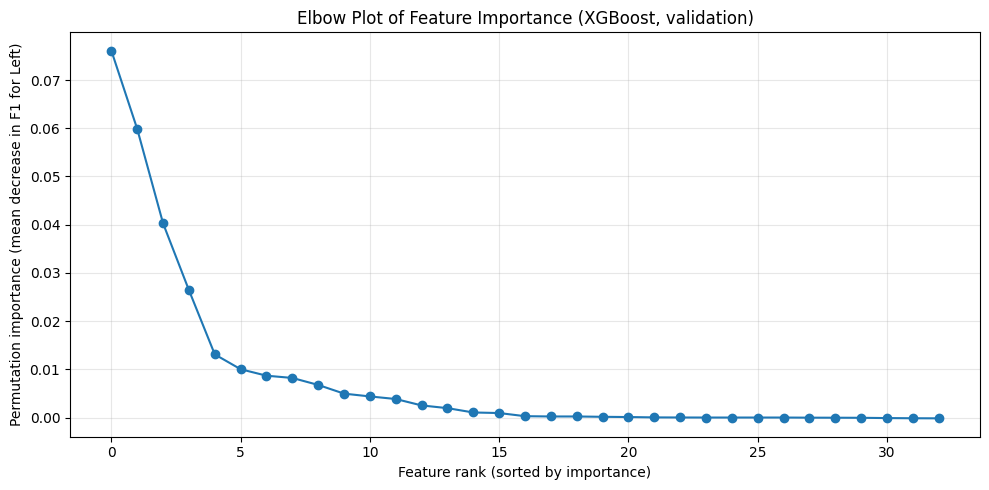


Chosen K (covers >= 80% of positive importance): 6

Top 6 most influential features for attrition (by permutation importance):


,rank,feature,importance_mean,importance_std
0,1,Job Level,0.076078,0.003446
1,2,Marital Status,0.059836,0.003285
2,3,Remote Work,0.040262,0.002707
3,4,Work-Life Balance,0.026413,0.003255
4,5,Number of Promotions,0.013091,0.001352
5,6,Education Level,0.010018,0.001611


In [64]:
# Elbow-style plot of permutation importance and data-driven top-K feature selection
import matplotlib.pyplot as plt

# 1) Make sure importances are sorted (descending)
perm_importance_df_sorted = perm_importance_df.sort_values(
    by="importance_mean", ascending=False
).reset_index(drop=True)

# 2) Elbow-style plot: all features, sorted by importance
plt.figure(figsize=(10, 5))
plt.plot(
    range(len(perm_importance_df_sorted)),
    perm_importance_df_sorted["importance_mean"],
    marker="o"
)
plt.xlabel("Feature rank (sorted by importance)")
plt.ylabel("Permutation importance (mean decrease in F1 for Left)")
plt.title("Elbow Plot of Feature Importance (XGBoost, validation)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Data-driven K: smallest K covering at least 80% of total positive importance
#    (we clip negatives at 0 so they don't reduce the total)
importance_pos = perm_importance_df_sorted["importance_mean"].clip(lower=0)
total_pos_importance = importance_pos.sum()

if total_pos_importance > 0:
    rel_importance = importance_pos / total_pos_importance
    cum_rel_importance = rel_importance.cumsum()

    # smallest K such that cumulative relative importance >= 0.8
    K = int((cum_rel_importance >= 0.80).idxmax() + 1)
else:
    # fallback: if everything is <= 0 (very unlikely), just take min(10, n_features)
    K = min(10, len(perm_importance_df_sorted))

print(f"\nChosen K (covers >= 80% of positive importance): {K}")

top_k_features = perm_importance_df_sorted.head(K).copy()
top_k_features["rank"] = range(1, K + 1)

print(f"\nTop {K} most influential features for attrition (by permutation importance):")
display(top_k_features[["rank", "feature", "importance_mean", "importance_std"]])


In [ ]:
# Build a fresh preprocessor_fe_lean with new transformers
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

print("Numeric features (lean):", numeric_features_fe_lean)
print("Ordinal features (lean):", ordinal_features_fe_lean)
print("Nominal features (lean):", nominal_features_fe_lean)

# 1) Numeric: impute missing with median + standardize
numeric_transformer_lean = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# 2) Ordinal: impute most frequent + OrdinalEncode
#    We let categories='auto' here; for a tree model like XGBoost,
#    the exact numeric codes for ordered categories matter less.
ordinal_transformer_lean = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(
        categories="auto",
        handle_unknown="use_encoded_value",
        unknown_value=-1
    )),
])

# 3) Nominal: impute most frequent + OneHotEncode (drop='first' to avoid dummy trap, like earlier)
nominal_transformer_lean = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        drop="first",
        sparse_output=False  # if using sklearn <1.2, use 'sparse=False' instead
    )),
])

# 4) Combine into a ColumnTransformer
preprocessor_fe_lean = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lean, numeric_features_fe_lean),
        ("ord", ordinal_transformer_lean, ordinal_features_fe_lean),
        ("nom", nominal_transformer_lean, nominal_features_fe_lean),
    ],
    remainder="drop",
)

preprocessor_fe_lean


Numeric features (lean): ['Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents', 'Company Tenure', 'TenurePerAge', 'IncomePerDependent']
Ordinal features (lean): ['Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 'Education Level', 'Job Level', 'Company Size', 'Company Reputation', 'Employee Recognition', 'AgeGroup']
Nominal features (lean): ['Gender', 'Job Role', 'Overtime', 'Marital Status', 'Remote Work']


,transformers,"[('num', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [ ]:
# Define lean XGBoost model + pipeline

# scale_pos_weight for TRAIN ONLY
neg_count_train = (y_train == 0).sum()
pos_count_train = (y_train == 1).sum()
scale_pos_weight_lean = neg_count_train / pos_count_train
print(f"scale_pos_weight_lean (neg/pos on train) = {scale_pos_weight_lean:.3f}")

best_xgb_params = study_xgb.best_trial.params

xgb_lean = XGBClassifier(
    n_estimators=best_xgb_params["n_estimators"],
    max_depth=best_xgb_params["max_depth"],
    learning_rate=best_xgb_params["learning_rate"],
    subsample=best_xgb_params["subsample"],
    colsample_bytree=best_xgb_params["colsample_bytree"],
    min_child_weight=best_xgb_params["min_child_weight"],
    reg_lambda=best_xgb_params["reg_lambda"],
    reg_alpha=best_xgb_params["reg_alpha"],
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight_lean,
    n_jobs=-1,
    random_state=42,
)

xgb_lean_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_fe_lean),
    ("model", xgb_lean),
])

xgb_lean_pipeline


scale_pos_weight_lean (neg/pos on train) = 1.103


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# Fit lean XGBoost pipeline
xgb_lean_pipeline.fit(X_train, y_train)

print("Lean XGBoost pipeline fitted on training split.")


Lean XGBoost pipeline fitted on training split.


In [ ]:
# Threshold sweep for the LEAN XGBoost model on the validation set

# Get predicted probabilities for class 1 (Left) on validation from the LEAN pipeline
y_val_proba_xgb_lean = xgb_lean_pipeline.predict_proba(X_val)[:, 1]

# Same threshold grid as before
thresholds = np.arange(0.20, 0.81, 0.05)  # 0.20, 0.25, ..., 0.80

threshold_results_lean = []
for thr in thresholds:
    metrics_thr = compute_metrics_at_threshold(
        y_true=y_val,
        y_proba=y_val_proba_xgb_lean,
        threshold=thr,
        pos_label=POS_LABEL
    )
    threshold_results_lean.append(metrics_thr)

xgb_lean_threshold_results = pd.DataFrame(threshold_results_lean).set_index("threshold")
xgb_lean_threshold_results


,accuracy,precision_pos,recall_pos,f1_pos,f1_macro
threshold,,,,,
0.20,0.673070,0.595143,0.977241,0.739766,0.650086
0.25,0.698909,0.618895,0.954658,0.750954,0.685160
0.30,0.718624,0.640720,0.929428,0.758531,0.710723
0.35,0.733389,0.663257,0.892378,0.760945,0.729799
0.40,0.744211,0.685036,0.855328,0.760769,0.742980
0.45,0.748322,0.704916,0.809633,0.753654,0.748204
0.50,0.754446,0.730452,0.766408,0.747998,0.754285
0.55,0.756040,0.758718,0.714008,0.735684,0.754585
0.60,0.750839,0.783284,0.658080,0.715244,0.746884


In [ ]:
# Choose best threshold by F1(Left) and evaluate LEAN model on validation

# Find threshold that maximizes F1 for class 1 (Left)
best_idx_lean = xgb_lean_threshold_results["f1_pos"].idxmax()
best_row_lean = xgb_lean_threshold_results.loc[best_idx_lean]

BEST_THRESHOLD_XGB_LEAN = float(best_idx_lean)

print("=== Best threshold for LEAN XGBoost by F1(Left) on validation ===")
print(f"Best threshold        : {BEST_THRESHOLD_XGB_LEAN:.2f}")
print(f"Accuracy              : {best_row_lean['accuracy']:.4f}")
print(f"Precision (Left=1)    : {best_row_lean['precision_pos']:.4f}")
print(f"Recall    (Left=1)    : {best_row_lean['recall_pos']:.4f}")
print(f"F1-score (Left=1)     : {best_row_lean['f1_pos']:.4f}")
print(f"Macro F1              : {best_row_lean['f1_macro']:.4f}")

# Hard predictions at the best threshold
y_val_pred_xgb_lean_best = (y_val_proba_xgb_lean >= BEST_THRESHOLD_XGB_LEAN).astype(int)

# ROC-AUC for the LEAN model (threshold-independent)
xgb_lean_val_roc_auc = roc_auc_score(y_val, y_val_proba_xgb_lean)
print(f"\nROC-AUC (validation, LEAN XGBoost) = {xgb_lean_val_roc_auc:.4f}")

# Detailed evaluation using our common helper
xgb_lean_best_thr_metrics = evaluate_binary_classifier(
    y_true=y_val,
    y_pred=y_val_pred_xgb_lean_best,
    y_proba=y_val_proba_xgb_lean,
    pos_label=POS_LABEL,
    model_name=f"XGBoost LEAN (Optuna) @ threshold={BEST_THRESHOLD_XGB_LEAN:.2f}"
)

# Store summary dict for later comparison
xgb_lean_summary_tuned = {
    "Model": f"XGBoost_Lean_thr_{BEST_THRESHOLD_XGB_LEAN:.2f}",
    **xgb_lean_best_thr_metrics
}


=== Best threshold for LEAN XGBoost by F1(Left) on validation ===
Best threshold        : 0.35
Accuracy              : 0.7334
Precision (Left=1)    : 0.6633
Recall    (Left=1)    : 0.8924
F1-score (Left=1)     : 0.7609
Macro F1              : 0.7298

ROC-AUC (validation, LEAN XGBoost) = 0.8503

=== Evaluation for XGBoost LEAN (Optuna) @ threshold=0.35 ===
Accuracy   : 0.7334
Precision  : 0.6633
Recall     : 0.8924
F1-score   : 0.7609
Macro F1   : 0.7298
ROC-AUC    : 0.8503

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.59      0.70      6252
           1       0.66      0.89      0.76      5668

    accuracy                           0.73     11920
   macro avg       0.76      0.74      0.73     11920
weighted avg       0.77      0.73      0.73     11920

Confusion matrix (rows=true, cols=pred):
[[3684 2568]
 [ 610 5058]]


In [ ]:
# Compare FULL vs LEAN XGBoost tuned models on validation

comparison_rows = []

# Full XGBoost tuned summary (from earlier threshold tuning)
comparison_rows.append(xgb_best_summary_tuned)

# Lean XGBoost tuned summary (from the new experiment)
comparison_rows.append(xgb_lean_summary_tuned)

model_comparison_df = pd.DataFrame(comparison_rows).set_index("Model")

# Display key metrics for comparison
model_comparison_df[["accuracy", "precision_pos", "recall_pos", "f1_pos", "f1_macro", "roc_auc"]]


,accuracy,precision_pos,recall_pos,f1_pos,f1_macro,roc_auc
Model,,,,,,
XGBoost_Optuna_thr_0.35,0.735403,0.666182,0.889026,0.761638,0.732158,0.850550
XGBoost_Lean_thr_0.35,0.733389,0.663257,0.892378,0.760945,0.729799,0.850263


In [ ]:
# Build final LEAN XGBoost pipeline for FULL training data

# Recompute scale_pos_weight on FULL training data
neg_count_full_lean = (y_train_fe_full == 0).sum()
pos_count_full_lean = (y_train_fe_full == 1).sum()
scale_pos_weight_full_lean = neg_count_full_lean / pos_count_full_lean

print(f"scale_pos_weight_full_lean (neg/pos on full train) = {scale_pos_weight_full_lean:.3f}")

# Use the same best hyperparameters found by Optuna
best_xgb_params = study_xgb.best_trial.params

xgb_final_lean = XGBClassifier(
    n_estimators=best_xgb_params["n_estimators"],
    max_depth=best_xgb_params["max_depth"],
    learning_rate=best_xgb_params["learning_rate"],
    subsample=best_xgb_params["subsample"],
    colsample_bytree=best_xgb_params["colsample_bytree"],
    min_child_weight=best_xgb_params["min_child_weight"],
    reg_lambda=best_xgb_params["reg_lambda"],
    reg_alpha=best_xgb_params["reg_alpha"],
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight_full_lean,
    n_jobs=-1,
    random_state=42,
)

# Reuse the same preprocessor_fe_lean (defined earlier) but now in a new pipeline
xgb_final_lean_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_fe_lean),
    ("model", xgb_final_lean),
])

xgb_final_lean_pipeline


scale_pos_weight_full_lean (neg/pos on full train) = 1.103


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# Fit the final LEAN XGBoost pipeline on the FULL training data
xgb_final_lean_pipeline.fit(X_train_fe_full, y_train_fe_full)

print("Final LEAN XGBoost pipeline fitted on FULL training data.")


Final LEAN XGBoost pipeline fitted on FULL training data.


In [ ]:
# Evaluate final LEAN XGBoost on the TEST set using BEST_THRESHOLD_XGB_LEAN

print(f"Using BEST_THRESHOLD_XGB_LEAN from validation = {BEST_THRESHOLD_XGB_LEAN:.2f}")

# 1) Predicted probabilities for class 1 (Left) on test set
y_test_proba_xgb_lean = xgb_final_lean_pipeline.predict_proba(X_test_fe_full)[:, 1]

# 2) Hard predictions using the tuned threshold
y_test_pred_xgb_lean = (y_test_proba_xgb_lean >= BEST_THRESHOLD_XGB_LEAN).astype(int)

# 3) ROC-AUC on test (threshold-independent)
xgb_final_lean_test_roc_auc = roc_auc_score(y_test_fe_full, y_test_proba_xgb_lean)
print(f"ROC-AUC (test, LEAN XGBoost final) = {xgb_final_lean_test_roc_auc:.4f}")

# 4) Full evaluation on test using our helper
xgb_final_lean_test_metrics = evaluate_binary_classifier(
    y_true=y_test_fe_full,
    y_pred=y_test_pred_xgb_lean,
    y_proba=y_test_proba_xgb_lean,
    pos_label=POS_LABEL,
    model_name=f"XGBoost LEAN FINAL @ threshold={BEST_THRESHOLD_XGB_LEAN:.2f} (TEST set)"
)

# 5) Store final test metrics for reporting
xgb_final_lean_test_summary = {
    "Model": f"XGBoost_Lean_Final_thr_{BEST_THRESHOLD_XGB_LEAN:.2f}_TEST",
    **xgb_final_lean_test_metrics
}

xgb_final_lean_test_summary


Using BEST_THRESHOLD_XGB_LEAN from validation = 0.35
ROC-AUC (test, LEAN XGBoost final) = 0.8526

=== Evaluation for XGBoost LEAN FINAL @ threshold=0.35 (TEST set) ===
Accuracy   : 0.7317
Precision  : 0.6581
Recall     : 0.8982
F1-score   : 0.7596
Macro F1   : 0.7280
ROC-AUC    : 0.8526

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.58      0.70      7868
           1       0.66      0.90      0.76      7032

    accuracy                           0.73     14900
   macro avg       0.76      0.74      0.73     14900
weighted avg       0.77      0.73      0.73     14900

Confusion matrix (rows=true, cols=pred):
[[4586 3282]
 [ 716 6316]]


{'Model': 'XGBoost_Lean_Final_thr_0.35_TEST',
 'accuracy': 0.7316778523489933,
 'precision_pos': 0.65805376120025,
 'recall_pos': 0.8981797497155859,
 'f1_pos': 0.759591100420926,
 'f1_macro': 0.7280111918201821,
 'roc_auc': 0.8526399922527159}

In [ ]:
# Build a test evaluation DataFrame with predicted probabilities and true labels

# If this is already computed in Cell 36, you can skip recomputing
y_test_proba_xgb_lean = xgb_final_lean_pipeline.predict_proba(X_test_fe_full)[:, 1]

test_eval_df = X_test_fe_full.copy()
test_eval_df["Attrition"] = y_test_fe_full.values        # true label (0/1)
test_eval_df["attrition_proba"] = y_test_proba_xgb_lean  # model probability for class 1 (Left)

test_eval_df.head()


,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,DistanceBand,LongCommuteFlag,PromotionRatePerYear,DependentsBand,TenurePerAge,IncomePerTenure,IncomePerDependent,HighWorkloadRiskFlag,Attrition,attrition_proba
0,36.0,Male,13.0,Healthcare,8029.0,Excellent,High,Average,1.0,Yes,...,Far,1,0.076923,Few,0.361111,617.615385,4014.500000,0,0,0.357698
1,35.0,Male,7.0,Education,4563.0,Good,High,Average,1.0,Yes,...,Medium,0,0.142857,Many,0.200000,651.857143,912.600000,0,1,0.788990
2,50.0,Male,7.0,Education,5583.0,Fair,High,Average,3.0,Yes,...,Near,0,0.428571,Few,0.140000,797.571429,1861.000000,1,0,0.050597
3,58.0,Male,44.0,Media,5525.0,Fair,Very High,High,0.0,Yes,...,Medium,0,0.000000,Many,0.758621,125.568182,1105.000000,1,1,0.913275
4,39.0,Male,24.0,Education,4604.0,Good,High,Average,0.0,Yes,...,Medium,0,0.000000,Many,0.615385,191.833333,657.714286,0,0,0.018284


In [ ]:
# Global feature insights for top 6 drivers (mean probability and actual attrition rate)

key_features = [
    "Job Level",
    "Marital Status",
    "Remote Work",
    "Work-Life Balance",
    "Number of Promotions",
    "Education Level"
]

feature_insights = {}

for col in key_features:
    # Group by feature and compute mean predicted probability + actual attrition rate
    grp = (
        test_eval_df
        .groupby(col)
        .agg(
            mean_attrition_proba=("attrition_proba", "mean"),
            actual_attrition_rate=("Attrition", "mean"),
            count=("Attrition", "size")
        )
        .sort_values("mean_attrition_proba", ascending=False)
    )
    feature_insights[col] = grp
    print(f"\n=== Attrition risk by {col} (sorted by predicted risk) ===")
    display(grp)



=== Attrition risk by Job Level (sorted by predicted risk) ===


,mean_attrition_proba,actual_attrition_rate,count
Job Level,,,
Entry,0.644784,0.636056,5913
Mid,0.472424,0.448270,5925
Senior,0.230417,0.200849,3062



=== Attrition risk by Marital Status (sorted by predicted risk) ===


,mean_attrition_proba,actual_attrition_rate,count
Marital Status,,,
Single,0.674686,0.666086,5166
Divorced,0.428599,0.412506,2223
Married,0.383311,0.356011,7511



=== Attrition risk by Remote Work (sorted by predicted risk) ===


,mean_attrition_proba,actual_attrition_rate,count
Remote Work,,,
No,0.542966,0.526242,12061
Yes,0.270706,0.241282,2839



=== Attrition risk by Work-Life Balance (sorted by predicted risk) ===


,mean_attrition_proba,actual_attrition_rate,count
Work-Life Balance,,,
Poor,0.601210,0.604629,2074
Fair,0.584142,0.579300,4483
Good,0.431045,0.396270,5630
Excellent,0.377756,0.350166,2713



=== Attrition risk by Number of Promotions (sorted by predicted risk) ===


,mean_attrition_proba,actual_attrition_rate,count
Number of Promotions,,,
2.0,0.507455,0.486545,2750
0.0,0.506935,0.490779,7429
1.0,0.503144,0.487352,3716
4.0,0.290446,0.248756,201
3.0,0.283170,0.232587,804



=== Attrition risk by Education Level (sorted by predicted risk) ===


,mean_attrition_proba,actual_attrition_rate,count
Education Level,,,
High School,0.505978,0.487722,2932
Associate Degree,0.503990,0.494644,3734
Master’s Degree,0.502856,0.483505,3001
Bachelor’s Degree,0.497991,0.475028,4505
PhD,0.273772,0.225275,728


In [ ]:
# Create risk buckets based on predicted probabilities and summarize them

def bucket_risk(p):
    if p < 0.25:
        return "Low"
    elif p < 0.50:
        return "Medium"
    else:
        return "High"

test_eval_df["risk_bucket"] = test_eval_df["attrition_proba"].apply(bucket_risk)

risk_summary = (
    test_eval_df
    .groupby("risk_bucket")
    .agg(
        n_employees=("Attrition", "size"),
        avg_attrition_proba=("attrition_proba", "mean"),
        actual_attrition_rate=("Attrition", "mean")
    )
    .sort_values("avg_attrition_proba", ascending=False)
)

print("=== Risk bucket summary (TEST set) ===")
display(risk_summary)


=== Risk bucket summary (TEST set) ===


,n_employees,avg_attrition_proba,actual_attrition_rate
risk_bucket,,,
High,7367,0.742363,0.735985
Medium,3639,0.377590,0.353394
Low,3894,0.121781,0.083205


In [ ]:
# Save the final LEAN pipeline and the chosen threshold for deployment

import joblib
import json

# Save the full preprocessing + model pipeline
joblib.dump(xgb_final_lean_pipeline, "xgb_lean_attrition_pipeline.joblib")

# Save threshold and any metadata you want
deploy_config = {
    "best_threshold_xgb_lean": float(BEST_THRESHOLD_XGB_LEAN),
    "model_file": "xgb_lean_attrition_pipeline.joblib"
}

with open("xgb_lean_attrition_config.json", "w") as f:
    json.dump(deploy_config, f, indent=2)

print("Saved model to 'xgb_lean_attrition_pipeline.joblib'")
print("Saved config to 'xgb_lean_attrition_config.json'")


Saved model to 'xgb_lean_attrition_pipeline.joblib'
Saved config to 'xgb_lean_attrition_config.json'


## SHAP

In [ ]:
import shap

n_samples = 1000
test_sample = X_test_fe_full.sample(n=min(n_samples, len(X_test_fe_full)), random_state=42)

# Transform sample through the LEAN preprocessor
preprocess_lean = xgb_final_lean_pipeline.named_steps["preprocess"]
model_lean = xgb_final_lean_pipeline.named_steps["model"]

X_test_sample_transformed = preprocess_lean.transform(test_sample)

# Get feature names after preprocessing (these are what the XGBoost model sees)
shap_feature_names = preprocess_lean.get_feature_names_out()


In [ ]:
# Build TreeExplainer for the lean XGBoost model and compute SHAP values

explainer_lean = shap.TreeExplainer(model_lean)
shap_values_lean = explainer_lean(X_test_sample_transformed)

# shap_values_lean.values is a numpy array of shape (n_samples, n_features)
shap_values_array = shap_values_lean.values

shap_values_array.shape, len(shap_feature_names)


((1000, 27), 27)

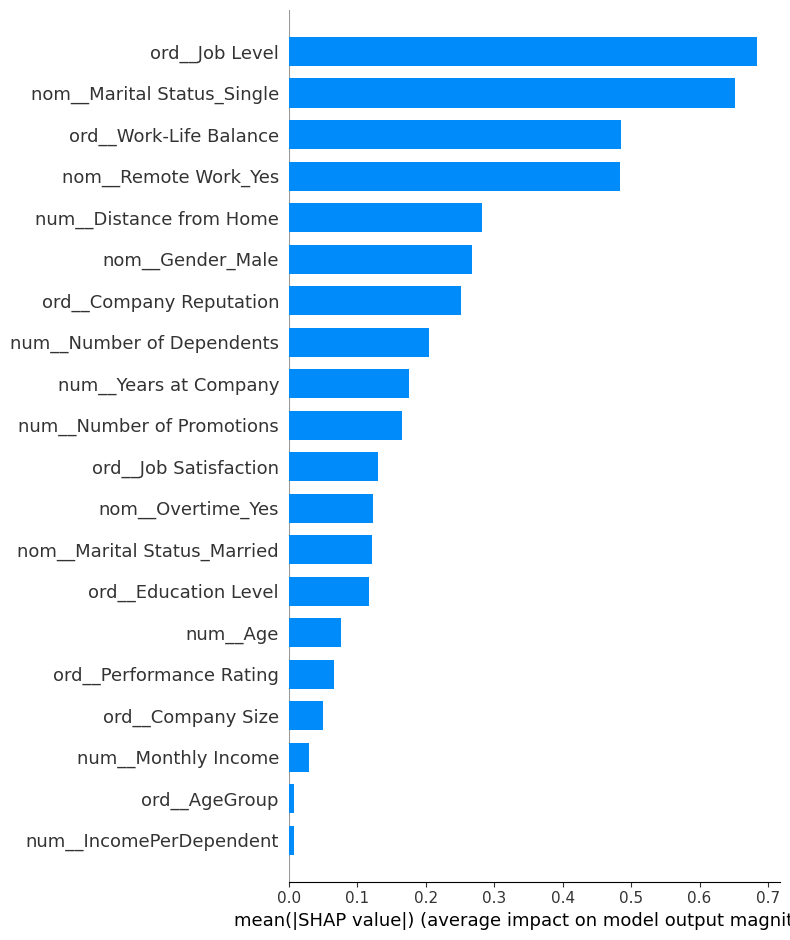

In [87]:
# SHAP Cell 3: Global feature importance bar plot (mean |SHAP|)

shap.summary_plot(
    shap_values_array,
    X_test_sample_transformed,
    feature_names=shap_feature_names,
    plot_type="bar",
    max_display=20  # change if you want more/less features
)


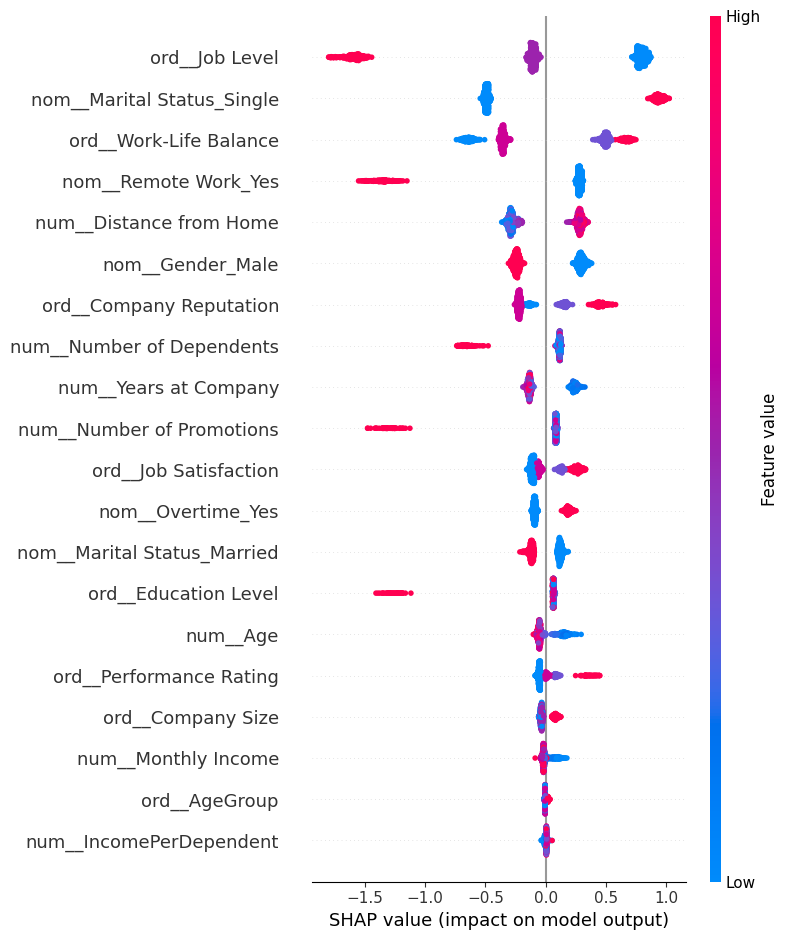

In [88]:
# SHAP Cell 4: SHAP summary (beeswarm) plot

shap.summary_plot(
    shap_values_array,
    X_test_sample_transformed,
    feature_names=shap_feature_names,
    max_display=20  # top 20 features
)
